In [21]:
import json
import pandas as pd
from src.comparator import compare_metadata, Comparator, print_diff, print_correctly_extracted
import src.datasets as load
from src.kuba_information_extractor import KubaInformationExtractor
import pprint

DATA_PATH = 'data/'
data_sets = load.load(DATA_PATH)

import numpy as np  
import re  
from sklearn.datasets import load_files  
import pickle  

from src.morf_utils import MorfWrapper
from src.compare_utils import deogonkify
import morfeusz2

translation = {"any": 0, "professional": 1, "student": 2}

In [22]:
X = []
y = []

for d in data_sets:
    content = d["content"]
    category = d["meta"]["preferredOccupation"]
    if category is None:
        category = 'any'
    X.append(content)
    y.append(translation[category])
    
y = np.array(y)

In [23]:
documents = []

for sen in range(0, len(X)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    documents.append(document)

In [24]:

stopwords = load.load_stopwords();

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer(max_features=500, min_df=1, ngram_range=(1, 2), lowercase=True)  
tfidf = tfidfconverter.fit(documents)

X = tfidf.transform(documents).toarray()  

In [32]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators=200) 
scores = cross_val_score(classifier, X, y, cv=4)
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test) 

array([0.87179487, 0.89473684, 0.89189189, 0.91666667])

0.8937725681146734

[[37  1  0]
 [ 2  0  0]
 [ 5  0  0]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5

   micro avg       0.82      0.82      0.82        45
   macro avg       0.28      0.32      0.30        45
weighted avg       0.71      0.82      0.76        45

0.8222222222222222


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


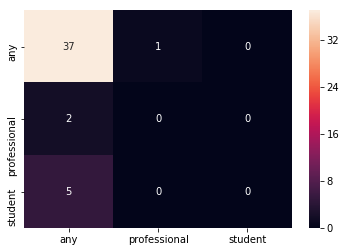

In [34]:
display (scores)
display (scores.mean())
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

conf_matrix_df = pd.DataFrame(confusion_matrix(y_test,y_pred), \
                                index= [key for key, value in translation.items()], \
                                columns=[key for key, value in translation.items()])
sns.heatmap(conf_matrix_df, annot=True)
plt.show()

In [29]:
with open('classifier_occupation.pickle', 'wb') as picklefile:  
    pickle.dump(classifier,picklefile)

In [30]:
pickle.dump(tfidf, open("tfidf_occupation.pickle", "wb"))